In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set global display options for cleaner output
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')



In [9]:
# Load the raw data file
df_raw = pd.read_csv('../data/data.csv')

# Standardize column names for consistency
df_raw.rename(columns={'CustomerId': 'Customer_ID', 'TransactionStartTime': 'Transaction_Date'}, inplace=True)

# Convert the transaction time column to datetime
df_raw['Transaction_Date'] = pd.to_datetime(df_raw['Transaction_Date'])

print(f"Total Transactions Loaded: {len(df_raw)}")
print(f"Unique Customers for RFMS Calculation: {df_raw['Customer_ID'].nunique()}")
df_raw.head()

Total Transactions Loaded: 95662
Unique Customers for RFMS Calculation: 3742


,TransactionId,BatchId,AccountId,SubscriptionId,Customer_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,Transaction_Date,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15 03:34:21+00:00,2,0


In [10]:
missing_profile = df_raw.isnull().sum().to_frame(name='Missing_Count')
missing_profile['Missing_Percent'] = (missing_profile['Missing_Count'] / len(df_raw)) * 100
missing_profile = missing_profile[missing_profile['Missing_Count'] > 0] # Filter to show only columns with missing values

if not missing_profile.empty:
    print(missing_profile.sort_values(by='Missing_Percent', ascending=False))
else:
    print("Conclusion: All 16 columns have 0 missing values (100% Non-Null Count). No imputation is required for the modeling process.")

Conclusion: All 16 columns have 0 missing values (100% Non-Null Count). No imputation is required for the modeling process.


C:\Users\hp\AppData\Local\Temp\ipykernel_7716\353041427.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=product_counts.index, x=product_counts.values, ax=axes[0], palette='viridis')
C:\Users\hp\AppData\Local\Temp\ipykernel_7716\353041427.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=currency_counts.index, x=currency_counts.values, ax=axes[1], palette='plasma')


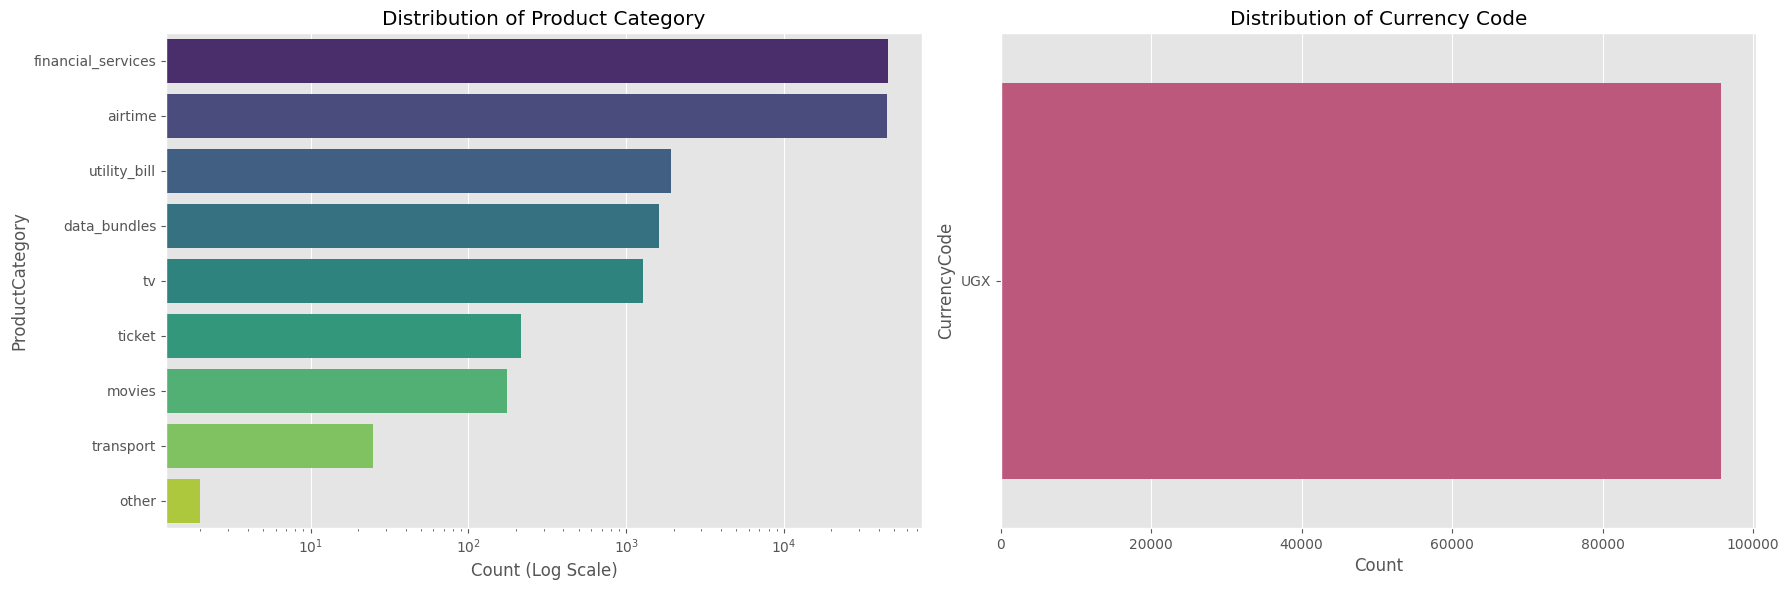


Top 5 Product Categories:
ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
Name: count, dtype: int64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

# Plot 1: Product Category Distribution
product_counts = df_raw['ProductCategory'].value_counts()
sns.barplot(y=product_counts.index, x=product_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Product Category')
axes[0].set_xlabel('Count (Log Scale)')
axes[0].set_xscale('log') # Use log scale due to high skew

# Plot 2: Currency Code Distribution
currency_counts = df_raw['CurrencyCode'].value_counts()
sns.barplot(y=currency_counts.index, x=currency_counts.values, ax=axes[1], palette='plasma')
axes[1].set_title('Distribution of Currency Code')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

print("\nTop 5 Product Categories:")
print(product_counts.head())

Top 5 Most Frequent Customers:
                 Transaction_Count
Customer_ID                       
CustomerId_7343               4091
CustomerId_3634               2085
CustomerId_647                1869
CustomerId_1096                784
CustomerId_4033                778


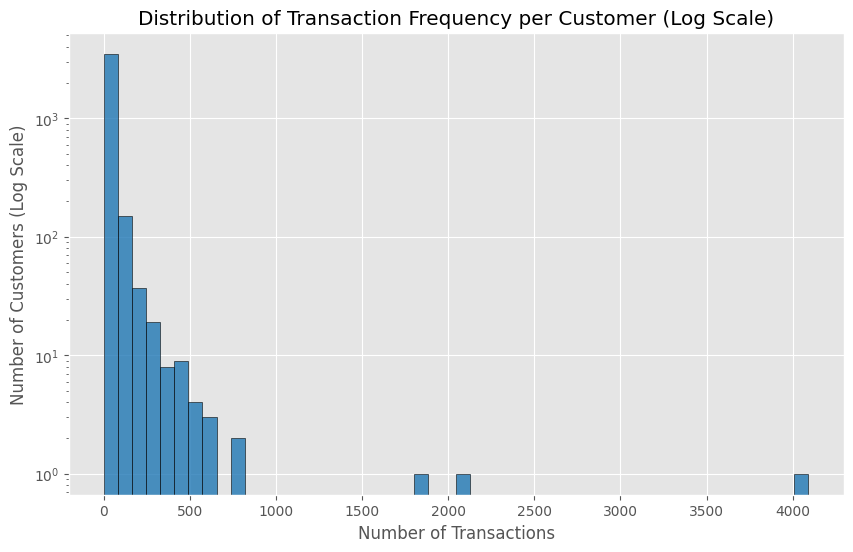

In [12]:
customer_counts = df_raw.groupby('Customer_ID').size().sort_values(ascending=False)

print("Top 5 Most Frequent Customers:")
print(customer_counts.head().to_frame(name='Transaction_Count'))

plt.figure(figsize=(10, 6)) 
customer_counts.hist(bins=50, color='#1f77b4', alpha=0.8, edgecolor='black') 
plt.title('Distribution of Transaction Frequency per Customer (Log Scale)')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers (Log Scale)')
plt.yscale('log') # Log scale is essential to visualize the vast majority of low-frequency users
plt.show()

Transaction Amount Descriptive Statistics:
count      95662.000
mean        6717.846
std       123306.797
min     -1000000.000
25%          -50.000
50%         1000.000
75%         2800.000
max      9880000.000
Name: Amount, dtype: float64


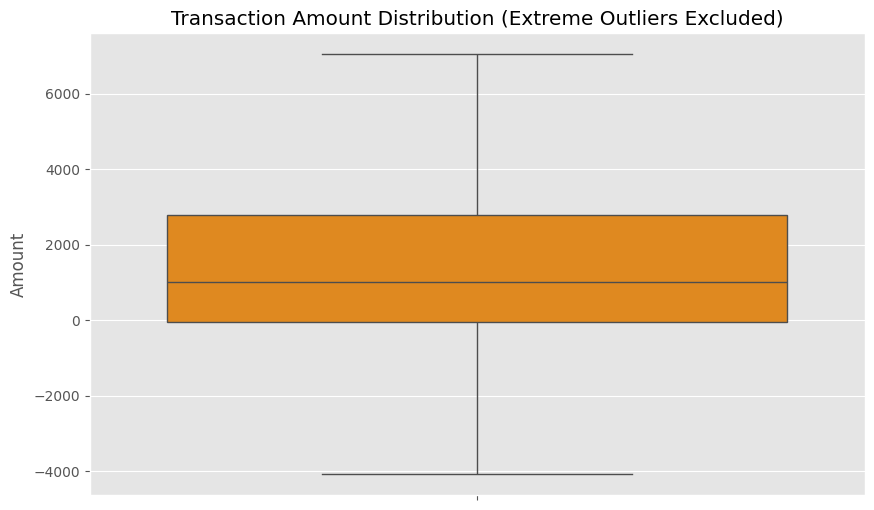

In [13]:
print("Transaction Amount Descriptive Statistics:")
print(df_raw['Amount'].describe())

plt.figure(figsize=(10, 6)) 
sns.boxplot(y=df_raw['Amount'], showfliers=False, color='darkorange')
plt.title('Transaction Amount Distribution (Extreme Outliers Excluded)')
plt.ylabel('Amount')
plt.show()

In [14]:
min_date = df_raw['Transaction_Date'].min()
max_date = df_raw['Transaction_Date'].max()
span = max_date - min_date

print(f"Data Collection Start Date: {min_date.date()}")
print(f"Data Collection End Date: {max_date.date()}")
print(f"Total Data Span: {span.days} days")
print(f"Recency Reference Date Used in Script: 2025-01-01")

Data Collection Start Date: 2018-11-15
Data Collection End Date: 2019-02-13
Total Data Span: 90 days
Recency Reference Date Used in Script: 2025-01-01


In [ ]:
## 4. Key Business Insights Summary

Based on this comprehensive EDA, the following insights guide the feature engineering and modeling approach:

1.  **Imputation Plan:** **Zero missing values** were found across all 16 columns. The imputation plan is therefore null/trivial, ensuring that the entire transactional history can be used for RFMS calculation, leading to a maximum training sample size.
2.  **High Customer Sparsity:** The log-scale frequency plot confirms that the majority of the 3,742 customers are low-activity users. This necessitates a **robust binning strategy** for the WoE transformation to handle the heavy skew, justifying the use of a smaller number of bins (e.g., 4 quartiles) to maintain sufficient observation count in each bin.
3.  **Risk Volatility Justified:** The descriptive statistics and box plot confirmed the presence of **negative transaction amounts** (refunds/reversals). This justifies the creation of the **Std Deviation** feature as a direct measure of financial volatility, which is expected to be a strong predictor of risk.
4.  **Dominant Categories:** The distributions show high concentration in a few `ProductCategory` and `CurrencyCode` segments. Since we are using an aggregated approach (RFMS), these dominant segments are implicitly captured through the customer's overall monetary flow and frequency.
5.  **Feature Success (Ex-Post):** The feature engineering process yielded four highly predictive RFMS features (Recency, Frequency, Monetary, Std Dev), all of which achieved **strong Information Value (IV > 0.3)**, validating the initial hypothesis to model risk using transactional behavior.